In [1]:
import importlib
import json
from pathlib import Path
from typing import Callable, Tuple

import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
import n2g
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import transformer_lens  # type: ignore[import]
from jaxtyping import Float, Int
from n2g import FeatureModel, NeuronStats, Tokenizer
from torch import Tensor
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint  # type: ignore[import]

from thesis.device import Device
from thesis.mas import WeightedSamplesStore, html
from thesis.sae.sae import SparseAutoencoder

importlib.reload(n2g)
importlib.reload(n2g.fit)
importlib.reload(n2g.neuron_model)

/home/user/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'n2g.neuron_model' from '/home/user/repos/Neuron2Graph/n2g/neuron_model.py'>

In [2]:
device = Device.get()

lm = HookedTransformer.from_pretrained("gelu-1l", device=device.torch())
tokenizer = Tokenizer(lm)

Loaded pretrained model gelu-1l into HookedTransformer


In [3]:
Path("~/Downloads/gelu-1l-sae_store.zip").expanduser()

PosixPath('/home/user/Downloads/gelu-1l-sae_store.zip')

In [4]:
mas_path = Path("../outputs/gelu-1l_sae_store.zip")
mas_store = WeightedSamplesStore.load(mas_path, device)
mas_store.num_samples_added()

43395

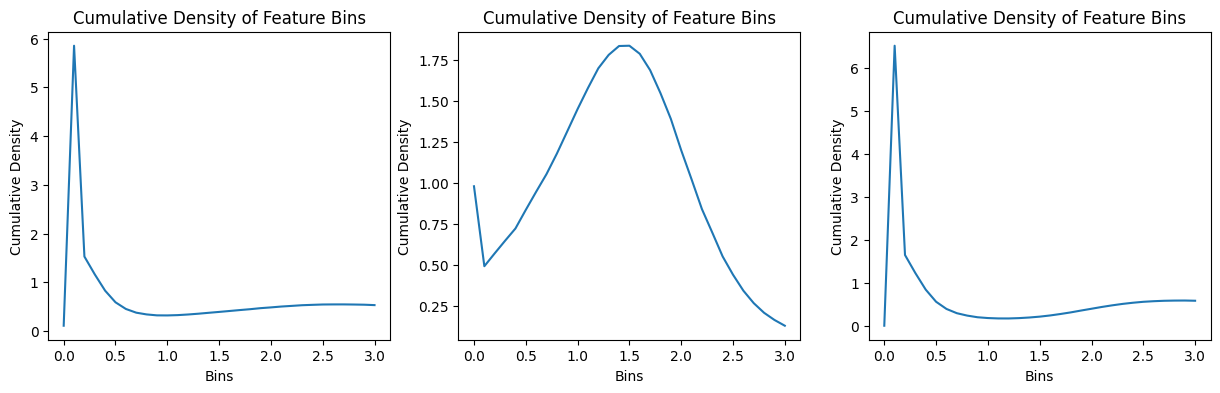

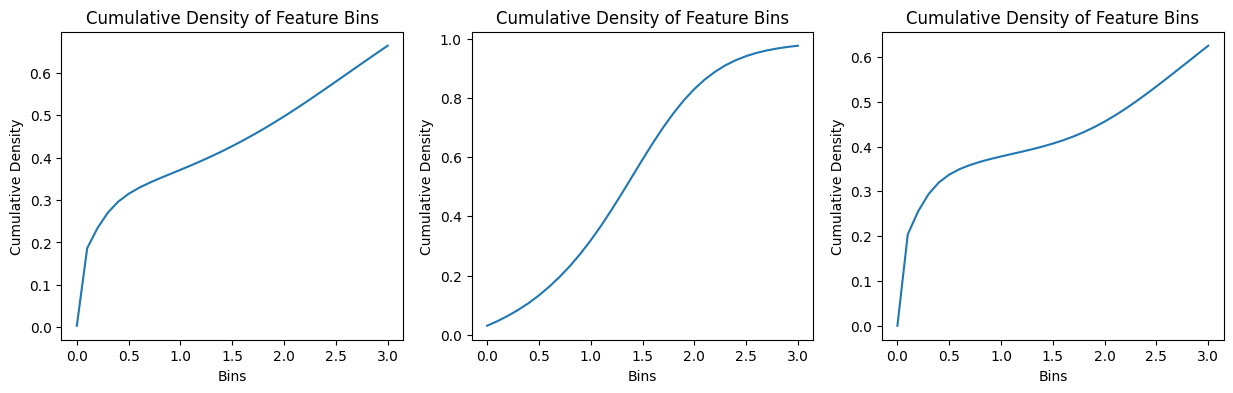

In [5]:
bins = mas_store.activation_bins.cpu().numpy()
plot_bins = np.append(bins, np.inf)
densities = mas_store.feature_densities.cpu().numpy()


def plot_density(
    ax: Axes, plot_bins: Float[np.ndarray, " num_bins"], densities: Float[np.ndarray, " num_bins"]
) -> None:
    densities = densities.sum(axis=0) / densities.sum() * plot_bins.size
    data = {"bins": plot_bins, "cumulative_densities": densities}
    global_df = pd.DataFrame(data)

    sns.lineplot(data=global_df, x="bins", y="cumulative_densities", ax=ax)

    ax.set_xlabel("Bins")
    ax.set_ylabel("Cumulative Density")
    ax.set_title("Cumulative Density of Feature Bins")


def plot_cum_density(
    ax: Axes, plot_bins: Float[np.ndarray, " num_bins"], densities: Float[np.ndarray, " num_bins"]
) -> None:
    densities = densities.sum(axis=0) / densities.sum()
    cum_densities = densities.cumsum(0)
    data = {"bins": plot_bins, "cumulative_densities": cum_densities}
    global_df = pd.DataFrame(data)

    sns.lineplot(data=global_df, x="bins", y="cumulative_densities", ax=ax)

    ax.set_xlabel("Bins")
    ax.set_ylabel("Cumulative Density")
    ax.set_title("Cumulative Density of Feature Bins")


fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plot_density(axes[0], plot_bins, densities)
plot_density(axes[1], plot_bins, densities[:2048])
plot_density(axes[2], plot_bins, densities[2048:])
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plot_cum_density(axes[0], plot_bins, densities)
plot_cum_density(axes[1], plot_bins, densities[:2048])
plot_cum_density(axes[2], plot_bins, densities[2048:])
plt.show()

(18432,)
18432


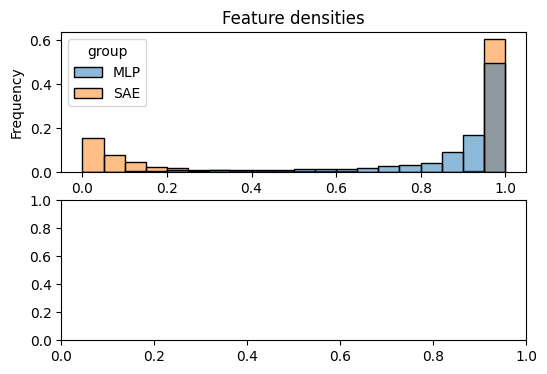

In [12]:
firings = 1 - densities[:, :6].sum(axis=1) / densities.sum(axis=1)
print(firings.shape)

mlp_df = pd.DataFrame({"firing_density": firings[:2048], "group": "MLP"})
sae_df = pd.DataFrame({"firing_density": firings[2048:], "group": "SAE"})

df = pd.concat([mlp_df, sae_df])

counts = {"MLP": 2048, "SAE": 2**14}

print(len(df["group"].map(counts)))

fig, axes = plt.subplots(2, 1, figsize=(6, 4))
sns.histplot(data=df, x="firing_density", hue="group", bins=20, weights=1 / df["group"].map(counts), ax=axes[0])

axes[0].set_xlabel("Density")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Feature densities")
plt.show()